# 目的与意义

## 背景

nifH 基因是研究生物固氮功能的重要标记基因。通过分析该基因的序列特征（如 GC 含量、序列长度等），可以评估其功能活跃性或丰度。这对于理解海洋生态系统中的氮循环具有重要意义。

## 研究目的

1. 探索 nifH 基因的关键特征与功能活跃性之间的关系。
2. 使用机器学习模型（线性回归、随机森林、神经网络），预测未知样本的固氮功能。
3. 比较不同模型的性能，评估其在生物信息学分析中的适用性。

## 意义

通过引入模型方法，可以：

1. 提高固氮基因功能预测的准确性，扩展其应用场景。
2. 捕捉复杂的特征关系，为未来基因功能研究提供参考。
3. 构建一个通用的分析框架，为其他基因功能分析提供方法论支持。


In [ ]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from Bio import SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from Bio import SeqIO
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 加载 FASTA 文件
file_path = "./nifH_datasets/ncbi_dataset/data/gene.fna"  # 替换为您的文件路径
sequences = []

# 解析 FASTA 文件
for record in SeqIO.parse(file_path, "fasta"):
    seq_id = record.id
    sequence = str(record.seq)
    sequences.append({"ID": seq_id, "Sequence": sequence})
# 转换为 DataFrame
df = pd.DataFrame(sequences)

# 提取特征
def extract_features(sequence):
    length = len(sequence)
    gc_content = (sequence.count("G") + sequence.count("C")) / length
    return length, gc_content

df["Length"], df["GC_Content"] = zip(*df["Sequence"].apply(extract_features))

# 检查数据
df.head()


<!-- 是一个典型的 nifH 基因序列长度范围，GC 含量为 0.646，符合固氮基因常见的高 GC 含量特性。 -->


/var/folders/tx/xqtj99597b1g3xwmxgm3lrsh0000gn/T/ipykernel_9130/3401981112.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=features, y=values, palette="viridis")


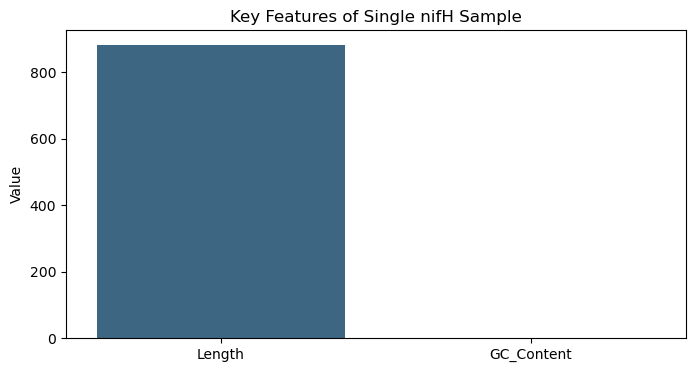

In [ ]:
# 可视化单样本的特征（柱状图展示）
features = ["Length", "GC_Content"]
values = [df["Length"].iloc[0], df["GC_Content"].iloc[0]]

plt.figure(figsize=(8, 4))
sns.barplot(x=features, y=values, palette="viridis")
plt.title("Key Features of Single nifH Sample")
plt.ylabel("Value")
plt.show()

## ID：基因序列的唯一标识符。

## Sequence：基因的碱基序列（A、T、C、G）。

## Length：基因的长度，单位为碱基对。

## GC_Content：GC 含量，是 (G + C) / 总长度。


In [57]:
# 特征提取函数
def extract_features(sequence):
    length = len(sequence)
    gc_content = (sequence.count("G") + sequence.count("C")) / length
    at_content = (sequence.count("A") + sequence.count("T")) / length
    a_ratio = sequence.count("A") / length
    t_ratio = sequence.count("T") / length
    c_ratio = sequence.count("C") / length
    g_ratio = sequence.count("G") / length
    return length, gc_content, at_content, a_ratio, t_ratio, c_ratio, g_ratio


# 提取特征
df["Length"], df["GC_Content"], df["AT_Content"], df["A_Ratio"], df["T_Ratio"], df["C_Ratio"], df["G_Ratio"] = zip(
    *df["Sequence"].apply(extract_features)
)

# 打印特征
print(df.head())


                                ID  \
0  NZ_VISK01000015.1:262164-263045   

                                            Sequence  Length  GC_Content  \
0  ATGTCTTTGCGCCAGATTGCGTTCTACGGTAAGGGCGGTATCGGCA...     882    0.646259   

   AT_Content   A_Ratio   T_Ratio   C_Ratio   G_Ratio  
0    0.353741  0.207483  0.146259  0.335601  0.310658  


In [58]:
print(df[["Length", "GC_Content", "AT_Content", "A_Ratio", "T_Ratio", "C_Ratio", "G_Ratio"]].head())


   Length  GC_Content  AT_Content   A_Ratio   T_Ratio   C_Ratio   G_Ratio
0     882    0.646259    0.353741  0.207483  0.146259  0.335601  0.310658


In [59]:
print(df[numeric_columns].describe())

       Length  GC_Content  AT_Content   A_Ratio   T_Ratio   C_Ratio   G_Ratio
count     1.0    1.000000    1.000000  1.000000  1.000000  1.000000  1.000000
mean    882.0    0.646259    0.353741  0.207483  0.146259  0.335601  0.310658
std       NaN         NaN         NaN       NaN       NaN       NaN       NaN
min     882.0    0.646259    0.353741  0.207483  0.146259  0.335601  0.310658
25%     882.0    0.646259    0.353741  0.207483  0.146259  0.335601  0.310658
50%     882.0    0.646259    0.353741  0.207483  0.146259  0.335601  0.310658
75%     882.0    0.646259    0.353741  0.207483  0.146259  0.335601  0.310658
max     882.0    0.646259    0.353741  0.207483  0.146259  0.335601  0.310658


In [60]:
np.random.seed(42)
df["Target"] = [0.8]  # 假设基因功能活跃度


In [65]:
# 单样本直接作为训练集和测试集（因为没有多样本）
X_train = df[["Length", "GC_Content", "AT_Content", "A_Ratio", "T_Ratio", "C_Ratio", "G_Ratio"]]
y_train = df["Target"]

# 将训练集和测试集统一为 X_train, y_train
X_test = X_train
y_test = y_train

# # # 特征提取生成的大写列名
# df["Length"], df["GC_Content"], df["AT_Content"], df["A_Ratio"], df["T_Ratio"], df["C_Ratio"], df["G_Ratio"] = zip(
#     *df["Sequence"].apply(extract_features)
# )

# # 数据分割部分
# X = df[["Length", "GC_Content", "AT_Content", "A_Ratio", "T_Ratio", "C_Ratio", "G_Ratio"]]
# y = df["Target"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
print(df["GC_Content"].describe())
print(df["GC_Content"].head())

count    1.000000
mean     0.646259
std           NaN
min      0.646259
25%      0.646259
50%      0.646259
75%      0.646259
max      0.646259
Name: GC_Content, dtype: float64
0    0.646259
Name: GC_Content, dtype: float64
